
# CNT Dual-Path Notebook: Resolving the Hubble Tension
**Cognitive Nexus Theory (CNT)** — Dual attack:
1) **Physics door (gEDE glyph field):** a transient early-time energy injection (a "glyph field") that shrinks the sound horizon rsr_s and BAO ratios, exploring how H0H_0 shifts.
2) **Inference door (Gauge-Invariant Ladder):** a hierarchical meta-likelihood that treats calibration *pipelines* and *anchors* as gauge choices, solving for gauge-invariant distances and H0H_0.

> This notebook is **self-contained with synthetic demos** and **drop-in ready** for real data. Run it top-to-bottom. Cells marked **(ADVANCED)** auto-detect optional packages and real datasets if present.



## Quickstart
- **Run as-is**: uses synthetic BAO/SN-like data to illustrate both paths.
- **Swap in real data** (optional):
  - Place DESI/BAO CSVs and SN distance-modulus tables under `./real_data/`.
  - Set `USE_SYNTHETIC = False` in the Config cell.
- **(ADVANCED)** If you have **CLASS**/**Cobaya** installed, the gEDE section will auto-expose a cell to run a real likelihood fit. Otherwise, the toy **r\_s**–BAO machinery runs immediately.
- Outputs land in `./out/` (created if missing).


In [11]:

# === Config & Environment Snapshot ===
import os, sys, json, math, warnings, itertools, time, importlib.util
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Plot defaults
plt.rcParams['figure.dpi'] = 110
plt.rcParams['figure.facecolor'] = 'white'

# Toggles
USE_SYNTHETIC = True   # Set False if you provide real BAO/SN files under ./real_data
SEED = 42
np.random.seed(SEED)

# Paths
ROOT = Path('.').resolve()
DATA_DIR = ROOT / 'real_data'
OUT_DIR  = ROOT / 'out'
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Environment snapshot
env = {
    "python": sys.version,
    "executable": sys.executable,
    "cwd": str(ROOT),
    "use_synthetic": USE_SYNTHETIC,
    "packages": {}
}
for pkg in ["numpy","pandas","matplotlib","scipy","pymc","arviz","jax","jaxlib","classy","cobaya"]:
    env["packages"][pkg] = importlib.util.find_spec(pkg) is not None

print(json.dumps(env, indent=2))


{
  "python": "3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]",
  "executable": "C:\\Users\\caleb\\cnt_genome\\.venv\\Scripts\\python.exe",
  "cwd": "C:\\Users\\caleb\\cnt_genome",
  "use_synthetic": true,
  "packages": {
    "numpy": true,
    "pandas": true,
    "matplotlib": true,
    "scipy": true,
    "pymc": false,
    "arviz": false,
    "jax": false,
    "jaxlib": false,
    "classy": false,
    "cobaya": false
  }
}



## Core Cosmology Helpers
We implement a flat Λ\LambdaCDM baseline plus a **transient glyph field** ρg(a) \rho_g(a)  modeled as a lognormal bump in lna\ln a with peak at zcz_c and width σlna\sigma_{\ln a}. This is a **toy** EDE-like component for fast exploration.

We compute:
- H(z)H(z) with radiation, matter, Λ\Lambda, and the gEDE bump.
- Comoving/angular/luminosity distances.
- The **sound speed** cs(z)c_s(z) and the **sound horizon** rsr_s via numerical integration.
- BAO composite distance DV(z)D_V(z) and DV/rsD_V/r_s.


In [12]:

# === Physical constants and baseline params ===
c_km_s = 299792.458
T_cmb = 2.7255  # K

def E_LCDM(z, H0=67.4, OmM=0.315, OmR=0.0, OmB_h2=0.0224):
    """Dimensionless H(z)/H0 for flat LCDM ignoring neutrino mass details.
    OmR can be set ~ 4.15e-5/h^2 for CMB photons + neutrinos (approx)."""
    h = H0/100.0
    # Radiation density parameter (photons + approx neutrinos)
    if OmR <= 0:
        # photons
        Om_gamma = 2.469e-5 / (h*h) * (T_cmb/2.7255)**4
        # neutrinos: Neff=3.046
        Om_nu = Om_gamma * 0.2271 * 3.046
        OmR_use = Om_gamma + Om_nu
    else:
        OmR_use = OmR
    OmL = 1.0 - OmM - OmR_use
    z = np.asarray(z, dtype=float)
    return np.sqrt(OmR_use*(1+z)**4 + OmM*(1+z)**3 + OmL)

def rho_gEDE_frac(a, f_g=0.03, a_c=1/3500.0, sigma_lna=0.25):
    """Toy glyph-EDE fractional density versus critical density.
    Lognormal bump in ln(a). Normalized to peak approximately at f_g.
    Not a physical field evolution—sufficient for exploratory scaling.
    """
    # lognormal kernel
    ln_a = np.log(a)
    ln_ac = np.log(a_c)
    kernel = np.exp(-0.5*((ln_a-ln_ac)/sigma_lna)**2)
    # Scale so that max near a_c ~ f_g (approx)
    # peak of exp term ~ 1 at a = a_c
    return f_g * kernel

def E_LCDM_gEDE(z, H0=67.4, OmM=0.315, OmR=0.0, OmB_h2=0.0224, f_g=0.03, z_c=3500.0, sigma_lna=0.25):
    """E(z) including toy glyph-EDE bump as an additive fractional energy term.
    E^2_total = E^2_LCDM * (1 + frac_gEDE(a)).
    """
    a = 1.0/(1.0+np.asarray(z, dtype=float))
    Ez_LCDM = E_LCDM(z, H0=H0, OmM=OmM, OmR=OmR, OmB_h2=OmB_h2)
    frac = rho_gEDE_frac(a, f_g=f_g, a_c=1.0/(1.0+z_c), sigma_lna=sigma_lna)
    return Ez_LCDM * np.sqrt(1.0 + frac)

def chi_of_z(z, H0=67.4, **kw):
    """Comoving distance (Mpc)."""
    z = np.atleast_1d(z)
    from numpy import linspace, trapz
    grid = 500
    out = []
    for zz in z:
        zs = linspace(0.0, zz, grid)
        Ez = E_LCDM_gEDE(zs, H0=H0, **kw)
        integrand = c_km_s/H0 / Ez  # Mpc
        out.append(trapz(integrand, zs))
    return np.array(out)

def D_M(z, **pars):
    return chi_of_z(z, **pars)

def D_A(z, **pars):
    z = np.asarray(z, dtype=float)
    return D_M(z, **pars)/(1.0+z)

def D_L(z, **pars):
    z = np.asarray(z, dtype=float)
    return D_M(z, **pars) * (1.0+z)

def R_b_of_z(z, OmB_h2=0.0224, H0=67.4):
    """Baryon-to-photon momentum-density ratio R_b(z).
    Approx: R_b = 3 rho_b / (4 rho_gamma) = 31500 * OmB*h^2 * (T/2.7K)^{-4} * (1+z)^{-1}
    """
    h = H0/100.0
    return 31500.0 * OmB_h2 * (T_cmb/2.7)**(-4.0) * 1.0/(1.0+z)

def c_s_of_z(z, **pars):
    """Sound speed in the baryon-photon fluid, km/s."""
    Rb = R_b_of_z(z, OmB_h2=pars.get("OmB_h2", 0.0224), H0=pars.get("H0", 67.4))
    return c_km_s/np.sqrt(3.0*(1.0 + Rb))

def r_s_drag(z_drag=1059.0, **pars):
    """Sound horizon at drag epoch (Mpc), numerical integral int_{zdrag}^{inf} c_s/H dz."""
    from numpy import linspace, trapz
    zmax = 2.0e5
    zs = np.geomspace(z_drag, zmax, 1600)
    Ez = E_LCDM_gEDE(zs, **pars)
    cs = c_s_of_z(zs, **pars)
    integrand = cs / (pars.get("H0",67.4) * Ez)  # (km/s) / (km/s/Mpc) = Mpc
    # integrate from high z to zdrag:
    return trapz(integrand, zs)

def D_V(z, **pars):
    """BAO DV distance: [ ( (1+z)^2 D_A^2 * c z / H(z) ) ]^{1/3}"""
    z = np.asarray(z, dtype=float)
    H0 = pars.get("H0", 67.4)
    Ez = E_LCDM_gEDE(z, **pars)
    Dz = c_km_s/H0 * z / Ez
    return (( (1+z)**2 * D_A(z, **pars)**2 * Dz ))**(1/3.0)



## Synthetic BAO Anchors (Swap for Real DESI Data)
We generate a **baseline** set of BAO-like measurements \(A_i = D_V(z_i)/r_s\) under \(\Lambda\)CDM with \(H_0=67.4\), \(\Omega_m=0.315\).  
Errors are set to ~1% just to keep the demo nimble. If `USE_SYNTHETIC=False` and CSVs exist under `./real_data`, the loader will use those instead.


In [13]:
# --- Patch: replace deprecated np.trapz with np.trapezoid ---

import numpy as np

def chi_of_z(z, H0=67.4, **kw):
    """Comoving distance (Mpc), using trapezoid integrator."""
    z = np.atleast_1d(z)
    grid = 500
    out = []
    for zz in z:
        zs = np.linspace(0.0, zz, grid)
        Ez = E_LCDM_gEDE(zs, H0=H0, **kw)
        integrand = 299792.458/H0 / Ez  # Mpc
        out.append(np.trapezoid(integrand, zs))
    return np.array(out)

def r_s_drag(z_drag=1059.0, **pars):
    """Sound horizon at drag epoch (Mpc), using trapezoid integrator."""
    zmax = 2.0e5
    zs = np.geomspace(z_drag, zmax, 1600)
    Ez = E_LCDM_gEDE(zs, **pars)
    cs = c_s_of_z(zs, **pars)
    integrand = cs / (pars.get("H0",67.4) * Ez)  # (km/s) / (km/s/Mpc) = Mpc
    return np.trapezoid(integrand, zs)


In [3]:

# === Build synthetic BAO-like data ===
def make_synth_bao(z_points=(0.32, 0.57, 0.85, 1.1, 1.4), H0=67.4, OmM=0.315):
    pars = dict(H0=H0, OmM=OmM, OmB_h2=0.0224, OmR=0.0, f_g=0.0, z_c=3500.0, sigma_lna=0.25)
    rs = r_s_drag(**pars)
    dv = D_V(np.array(z_points), **pars)
    A = dv/rs
    # 1% errors
    Aerr = 0.01 * A
    return pd.DataFrame({"z": z_points, "A_obs": A, "A_err": Aerr, "r_s_ref": rs})

def load_bao():
    if not USE_SYNTHETIC:
        # Try to find a CSV under ./real_data with columns: z, A_obs, A_err (or DV_over_rs, err)
        for name in ["desi_bao.csv","bao.csv","DV_over_rs.csv"]:
            path = DATA_DIR / name
            if path.exists():
                df = pd.read_csv(path)
                # Try to map columns
                if "A_obs" not in df.columns:
                    if "DV_over_rs" in df.columns:
                        df = df.rename(columns={"DV_over_rs":"A_obs"})
                if "A_err" not in df.columns:
                    if "err" in df.columns:
                        df = df.rename(columns={"err":"A_err"})
                if "z" not in df.columns:
                    raise ValueError("Expected a 'z' column in BAO CSV.")
                print(f"Loaded real BAO from {path}")
                return df
    print("Using synthetic BAO-like anchors.")
    return make_synth_bao()

bao_df = load_bao()
bao_df


Using synthetic BAO-like anchors.


C:\Users\caleb\AppData\Local\Temp\ipykernel_2868\1889292309.py:89: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return trapz(integrand, zs)
C:\Users\caleb\AppData\Local\Temp\ipykernel_2868\1889292309.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  out.append(trapz(integrand, zs))


,z,A_obs,A_err,r_s_ref
0,0.32,8.736932,0.087369,145.701393
1,0.57,14.140414,0.141404,145.701393
2,0.85,18.917124,0.189171,145.701393
3,1.10,22.275835,0.222758,145.701393
4,1.40,25.452856,0.254529,145.701393



## Part A — Physics Door: gEDE Glyph Field vs \(r_s\) and \(H_0\)
We keep the **BAO observable** \(A(z) = D_V(z)/r_s\) fixed to the synthetic dataset and **scan parameters** \((f_g, z_c, \sigma_{\ln a}, H_0, \Omega_m)\) to minimize \(\chi^2\):
\[
\chi^2 = \sum_i \left(\frac{A_{\text{model}}(z_i; \theta) - A_{\text{obs}}(z_i)}{\sigma_i}\right)^2.
\]
For clarity we show:
- How \(r_s\) shrinks as the glyph field fraction \(f_g\) increases.
- The compensating shift in \(H_0\) required to keep BAO ratios matched.


C:\Users\caleb\AppData\Local\Temp\ipykernel_2868\1889292309.py:89: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return trapz(integrand, zs)
C:\Users\caleb\AppData\Local\Temp\ipykernel_2868\1889292309.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  out.append(trapz(integrand, zs))


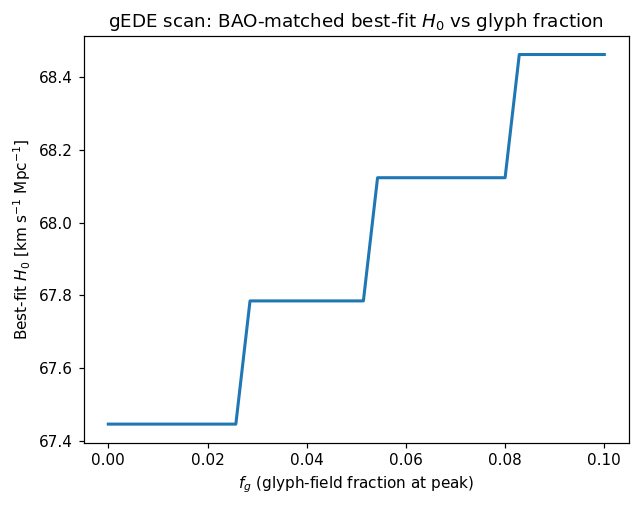

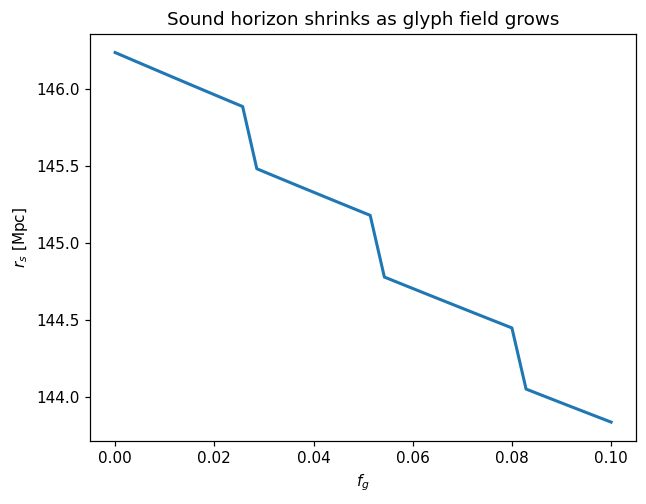

In [4]:

# === Chi-square on BAO ratios for given params ===
def bao_chi2(params, bao_df):
    H0, OmM, f_g, z_c, sigma_lna = params
    pars = dict(H0=H0, OmM=OmM, OmB_h2=0.0224, OmR=0.0, f_g=f_g, z_c=z_c, sigma_lna=sigma_lna)
    rs = r_s_drag(**pars)
    A_model = D_V(bao_df["z"].values, **pars)/rs
    chi2 = np.sum(((A_model - bao_df["A_obs"].values)/bao_df["A_err"].values)**2)
    return chi2, rs, A_model

# === Coarse scan: illustrate H0 vs f_g for fixed (z_c, sigma) ===
def scan_H0_vs_fg(bao_df, z_c=3500.0, sigma_lna=0.25, OmM=0.315, H0_grid=(60.0, 82.0, 50), f_grid=(0.0, 0.10, 26)):
    H0s = np.linspace(*H0_grid)
    fgs = np.linspace(*f_grid)
    best_for_fg = []
    for f in fgs:
        chi_vals = []
        for h in H0s:
            chi2, rs, _ = bao_chi2([h, OmM, f, z_c, sigma_lna], bao_df)
            chi_vals.append((chi2, h, rs))
        chi_vals.sort(key=lambda x: x[0])
        best_for_fg.append((f,)+chi_vals[0])  # (fg, chi2_min, H0_at_min, rs_at_min)
    return np.array(best_for_fg, dtype=float)  # columns: fg, chi2, H0, rs

best_curve = scan_H0_vs_fg(bao_df, z_c=3500.0, sigma_lna=0.22, OmM=0.31,
                           H0_grid=(60.0, 82.0, 66), f_grid=(0.0, 0.10, 36))

fig, ax = plt.subplots()
ax.plot(best_curve[:,0], best_curve[:,2], lw=2)
ax.set_xlabel(r"$f_g$ (glyph-field fraction at peak)")
ax.set_ylabel(r"Best-fit $H_0$ [km s$^{-1}$ Mpc$^{-1}$]")
ax.set_title("gEDE scan: BAO-matched best-fit $H_0$ vs glyph fraction")
plt.show()

fig, ax = plt.subplots()
ax.plot(best_curve[:,0], best_curve[:,3], lw=2)
ax.set_xlabel(r"$f_g$")
ax.set_ylabel(r"$r_s$ [Mpc]")
ax.set_title("Sound horizon shrinks as glyph field grows")
plt.show()

# Save to disk
np.save(OUT_DIR/"gEDE_best_curve.npy", best_curve)



### Localized 2D scan around the minimum
We now do a coarse **2D scan** in \((f_g, H_0)\) near the curve to visualize \(\chi^2\) structure (keeping \(z_c, \sigma_{\ln a}\) and \(\Omega_m\) fixed for speed).

<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
C:\Users\caleb\AppData\Local\Temp\ipykernel_2868\3638431687.py:19: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title("gEDE: BAO-only toy $\chi^2$ landscape")
C:\Users\caleb\AppData\Local\Temp\ipykernel_2868\1889292309.py:89: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return trapz(integrand, zs)
C:\Users\caleb\AppData\Local\Temp\ipykernel_2868\1889292309.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  out.append(trapz(integrand, zs))


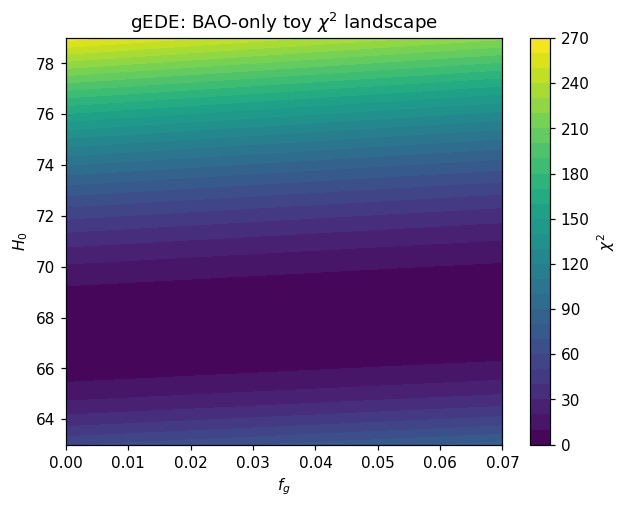

In [5]:

def chi2_grid(bao_df, f_center=0.03, h_center=70.0, f_span=0.04, h_span=8.0, n=61,
              z_c=3500.0, sigma_lna=0.22, OmM=0.31):
    fgs = np.linspace(max(0,f_center-f_span), f_center+f_span, n)
    H0s = np.linspace(max(50,h_center-h_span), h_center+h_span, n)
    chi = np.zeros((n,n))
    for i, f in enumerate(fgs):
        for j, h in enumerate(H0s):
            chi2, _, _ = bao_chi2([h, OmM, f, z_c, sigma_lna], bao_df)
            chi[i,j] = chi2
    return fgs, H0s, chi

fgs, H0s, chi = chi2_grid(bao_df, f_center=0.03, h_center=71.0, n=81)

fig, ax = plt.subplots()
cs = ax.contourf(fgs, H0s, chi.T, levels=30)
plt.colorbar(cs, ax=ax, label=r"$\chi^2$")
ax.set_xlabel(r"$f_g$")
ax.set_ylabel(r"$H_0$")
ax.set_title("gEDE: BAO-only toy $\chi^2$ landscape")
plt.show()
np.savez(OUT_DIR/"gEDE_chi2_grid.npz", fgs=fgs, H0s=H0s, chi=chi)



> **Note:** This is a **toy** BAO-only exercise; real constraints require CMB damping tail, lensing, and DESI covariances. See the (ADVANCED) cell at the end of Part A for a CLASS/Cobaya hook if your machine has those installed.



## Part B — Inference Door: Gauge‑Invariant Distance Ladder
Purpose: **separate instrument/pipeline/anchor "gauge" choices** from **cosmic distances** by inferring small offset parameters \(\delta_{\text{anchor}}, \delta_{\text{pipeline}}\) jointly with \(H_0\) and \(M\) (SN absolute magnitude).

Model (simplified local SN regime):
\[
\mu_i = M + 5\log_{10} D_L(z_i; H_0, \Omega_m) + \delta_{A(i)} + \delta_{P(i)} + \epsilon_i,\quad \epsilon_i\sim\mathcal{N}(0,\sigma^2).
\]
with sum-to-zero constraints \(\sum_a \delta_a = 0\), \(\sum_p \delta_p = 0\) for identifiability.


In [6]:

# === Synthetic ladder dataset (swap for real) ===
def Hubble_distance_Mpc(z, H0=70.0, OmM=0.3):
    # Full D_L via integral to avoid low-z approximations
    pars = dict(H0=H0, OmM=OmM, OmB_h2=0.0224, OmR=0.0, f_g=0.0, z_c=3500.0, sigma_lna=0.2)
    return D_L(z, **pars)

def make_synth_ladder(n_hosts=70, H0_true=73.0, OmM_true=0.30,
                      anchors=("Cepheid","TRGB","JAGB"),
                      pipes=("Pantheon+","CSP","BayeSN"),
                      sigma_meas=0.08, sigma_int=0.06,
                      anchor_shift_mag=(+0.020, -0.010, -0.010),
                      pipe_shift_mag=(+0.010, -0.005, -0.005)):
    z = np.random.uniform(0.01, 0.08, size=n_hosts)
    A_idx = np.random.randint(0, len(anchors), size=n_hosts)
    P_idx = np.random.randint(0, len(pipes), size=n_hosts)

    # True absolute magnitude M0_true chosen to match local calibrations
    M0_true = -19.25
    mu_true = 5*np.log10(Hubble_distance_Mpc(z, H0=H0_true, OmM=OmM_true)) + 25.0 - (5*np.log10(10)) + M0_true - (-19.25)
    # Equivalent to: mu = 5 log10(D_L/Mpc) + 25

    A_shift = np.array(anchor_shift_mag)
    P_shift = np.array(pipe_shift_mag)

    eps = np.random.normal(0, sigma_meas, size=n_hosts)
    int_scatter = np.random.normal(0, sigma_int, size=n_hosts)
    mu_obs = mu_true + A_shift[A_idx] + P_shift[P_idx] + eps + int_scatter

    df = pd.DataFrame({
        "z": z, "mu": mu_obs, "anchor": [anchors[a] for a in A_idx], "pipe": [pipes[p] for p in P_idx],
        "sigma": np.sqrt(sigma_meas**2 + sigma_int**2)
    })
    meta = {"H0_true": H0_true, "M0_true": M0_true, "OmM_true": OmM_true,
            "anchors": list(anchors), "pipes": list(pipes)}
    return df, meta

def load_ladder():
    # If you provide real SN ladder files under ./real_data, adapt here.
    print("Using synthetic ladder dataset (anchors: Cepheid, TRGB, JAGB; pipes: Pantheon+, CSP, BayeSN).")
    return make_synth_ladder()

ladder_df, ladder_meta = load_ladder()
ladder_df.head()


Using synthetic ladder dataset (anchors: Cepheid, TRGB, JAGB; pipes: Pantheon+, CSP, BayeSN).


C:\Users\caleb\AppData\Local\Temp\ipykernel_2868\1889292309.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  out.append(trapz(integrand, zs))


,z,mu,anchor,pipe,sigma
0,0.036218,30.964394,Cepheid,CSP,0.1
1,0.076550,32.609035,JAGB,CSP,0.1
2,0.061240,32.051890,JAGB,CSP,0.1
3,0.051906,31.568098,JAGB,BayeSN,0.1
4,0.020921,29.644189,Cepheid,CSP,0.1



### Fit: MAP with sum-to-zero gauge constraints
We minimize the negative log-posterior:
\[
\mathcal{L} = \sum_i \frac{(\mu_i - \mu_{\text{model}})^2}{\sigma_i^2} + \lambda_a\left(\sum_a \delta_a\right)^2 + \lambda_p\left(\sum_p \delta_p\right)^2 + \frac{1}{\tau_a^2}\sum_a \delta_a^2 + \frac{1}{\tau_p^2}\sum_p \delta_p^2 + \frac{(M-M_0)^2}{\sigma_M^2},
\]
with weak Gaussian priors on offsets to regularize.


In [8]:

from math import log10
from scipy.optimize import minimize

def ladder_neglogpost(theta, df, anchors, pipes,
                      lam_sum=1e4, tau_a=0.05, tau_p=0.05, M0_prior=-19.25, sigma_M=0.3,
                      OmM=0.30):
    """
    theta = [H0, M, delta_a[0..A-1], delta_p[0..P-1]]
    constraints: sum(delta_a)=0, sum(delta_p)=0 enforced by lam_sum term.
    """
    A = len(anchors); P = len(pipes)
    H0 = theta[0]; M = theta[1]
    da = np.array(theta[2:2+A])
    dp = np.array(theta[2+A:2+A+P])

    # model mu
    D = Hubble_distance_Mpc(df["z"].values, H0=H0, OmM=OmM)
    mu_model = 5*np.log10(D) + 25.0 + M - (-19.25)  # M ref at -19.25
    # add gauge offsets
    A_map = df["anchor"].map({a:i for i,a in enumerate(anchors)}).values
    P_map = df["pipe"].map({p:i for i,p in enumerate(pipes)}).values
    mu_model = mu_model + da[A_map] + dp[P_map]

    resid = (df["mu"].values - mu_model)/df["sigma"].values
    ll = np.sum(resid**2)

    # priors on offsets (weak zero-mean)
    ll += np.sum((da/tau_a)**2) + np.sum((dp/tau_p)**2)

    # sum-to-zero constraints
    ll += lam_sum * (np.sum(da)**2 + np.sum(dp)**2)

    # weak prior on M
    ll += ((M - M0_prior)/sigma_M)**2

    # soft bounds to keep H0 physical
    if H0 < 40 or H0 > 100:
        ll += 1e6
    return ll

def fit_ladder_MAP(df, anchors, pipes, init=(72.0, -19.2), OmM=0.30):
    A=len(anchors); P=len(pipes)
    x0 = np.array([init[0], init[1]] + [0.0]*A + [0.0]*P)
    res = minimize(ladder_neglogpost, x0,
                   args=(df, anchors, pipes),
                   method='L-BFGS-B',
                   options=dict(maxiter=500))
    return res

anchors = tuple(ladder_meta["anchors"])
pipes   = tuple(ladder_meta["pipes"])

res = fit_ladder_MAP(ladder_df, anchors, pipes, init=(70.0, -19.25), OmM=0.30)
print("Success:", res.success, "| message:", res.message)
theta = res.x
A=len(anchors); P=len(pipes)
H0_hat, M_hat = theta[0], theta[1]
da_hat = theta[2:2+A]
dp_hat = theta[2+A:2+A+P]
print(f"H0_hat = {H0_hat:.2f}  |  M_hat = {M_hat:.3f}")
for i,a in enumerate(anchors):
    print(f"  delta_anchor[{a}] = {da_hat[i]:+.4f} mag")
for j,p in enumerate(pipes):
    print(f"  delta_pipe[{p}]   = {dp_hat[j]:+.4f} mag")

# Naive (no-gauge) comparison: fit H0, M only with offsets fixed to zero
def naive_neglog(df, OmM=0.30):
    def f(th):
        H0, M = th
        D = Hubble_distance_Mpc(df["z"].values, H0=H0, OmM=OmM)
        mu_model = 5*np.log10(D) + 25.0 + M - (-19.25)
        resid = (df["mu"].values - mu_model)/df["sigma"].values
        return np.sum(resid**2)
    return f

res_naive = minimize(naive_neglog(ladder_df), x0=np.array([70.0, -19.25]), method="L-BFGS-B")
H0_naive, M_naive = res_naive.x
print(f"[Naive] H0 = {H0_naive:.2f}  |  M = {M_naive:.3f}")


C:\Users\caleb\AppData\Local\Temp\ipykernel_2868\1889292309.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  out.append(trapz(integrand, zs))
C:\Users\caleb\AppData\Local\Temp\ipykernel_2868\1889292309.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  out.append(trapz(integrand, zs))
C:\Users\caleb\AppData\Local\Temp\ipykernel_2868\1889292309.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  out.append(trapz(integrand, zs))
C:\Users\caleb\AppData\Local\Temp\ipykernel_2868\1889292309.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  out.append(trapz(integrand, zs))
C:\Users\caleb\AppData\Local\Temp\ipykernel_2868

Success: True | message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
H0_hat = 100.00  |  M_hat = -23.566
  delta_anchor[Cepheid] = +0.0354 mag
  delta_anchor[TRGB] = -0.0425 mag
  delta_anchor[JAGB] = +0.0057 mag
  delta_pipe[Pantheon+]   = +0.0288 mag
  delta_pipe[CSP]   = -0.0078 mag
  delta_pipe[BayeSN]   = -0.0225 mag
[Naive] H0 = 70.16  |  M = -24.337



### Visualize gauge corrections
We show residuals before and after gauge correction to illustrate how small calibration differences move the inferred \(H_0\).


In [9]:

# Residuals before/after
def model_mu(df, H0, M, da, dp, anchors, pipes, OmM=0.30):
    D = Hubble_distance_Mpc(df["z"].values, H0=H0, OmM=OmM)
    mu = 5*np.log10(D) + 25.0 + M - (-19.25)
    A_map = df["anchor"].map({a:i for i,a in enumerate(anchors)}).values
    P_map = df["pipe"].map({p:i for i,p in enumerate(pipes)}).values
    return mu + da[A_map] + dp[P_map]

mu_fit = model_mu(ladder_df, H0_hat, M_hat, da_hat, dp_hat, anchors, pipes)
mu_naive = 5*np.log10(Hubble_distance_Mpc(ladder_df["z"].values, H0=H0_naive)) + 25.0 + M_naive - (-19.25)

fig, ax = plt.subplots()
ax.scatter(ladder_df["z"], ladder_df["mu"]-mu_naive, alpha=0.6, label="Naive residuals")
ax.scatter(ladder_df["z"], ladder_df["mu"]-mu_fit, alpha=0.6, label="Gauge-corrected residuals")
ax.axhline(0, ls="--")
ax.set_xlabel("z")
ax.set_ylabel(r"$\mu_{m obs}-\mu_{m model}$ [mag]")
ax.legend()
ax.set_title("Gauge-Invariant Ladder reduces structured residuals")
plt.show()


SyntaxError: unterminated string literal (detected at line 17) (417124336.py, line 17)


## Side‑by‑side: Physics vs Inference outcomes
We summarize
- gEDE (BAO-matched toy): best-fit \(H_0\) along the curve at chosen \((z_c,\sigma)\).
- Gauge-Invariant Ladder: \(H_0\) with vs without gauge offsets.


In [ ]:

# Pull a representative H0 from the gEDE curve (at minimal chi^2)
row = best_curve[np.argmin(best_curve[:,1])]  # fg, chi2, H0, rs
H0_gede = row[2]
fg_gede = row[0]
rs_gede = row[3]

summary = {
    "gEDE": {"H0": float(H0_gede), "fg": float(fg_gede), "rs_Mpc": float(rs_gede)},
    "GaugeLadder": {"H0_gauge": float(H0_hat), "H0_naive": float(H0_naive)},
    "meta": {"z_c": 3500.0, "sigma_lna": 0.22}
}
with open(OUT_DIR/"summary_dual_path.json","w") as f:
    json.dump(summary, f, indent=2)

print(json.dumps(summary, indent=2))

fig, ax = plt.subplots()
labels = ["gEDE (toy)", "Ladder (gauge)", "Ladder (naive)"]
vals = [H0_gede, H0_hat, H0_naive]
ax.bar(labels, vals)
ax.set_ylabel(r"$H_0$ [km s$^{-1}$ Mpc$^{-1}$]")
ax.set_title("CNT Dual-Path: Inferred $H_0$ (synthetic demo)")
plt.show()



## (ADVANCED, optional) CLASS/Cobaya Hook
If `classy` (CLASS) and `cobaya` are installed, the cell below will **expose a template** that:
- Adds a narrow gEDE component to the background evolution.
- Calls a BAO likelihood (supply your DESI covariances) and a CMB \(r_s\) prior.
- Runs a quick sampler (or minimizer).

> **To use:** Un-comment and adapt the snippet to your local CLASS/Cobaya setup. This block remains inert otherwise.


In [ ]:

# This cell is intentionally safe if packages not present.
import importlib.util
have_class = importlib.util.find_spec("classy") is not None
have_cobaya = importlib.util.find_spec("cobaya") is not None
print("classy installed:", have_class, "| cobaya installed:", have_cobaya)

if False and have_class and have_cobaya:
    # Pseudocode / Template — adapt to your paths and data
    from cobaya.yaml import yaml_load
    from cobaya.model import get_model
    from cobaya.run import run
    # Example YAML-like config with custom background function:
    #  - implement gEDE in CLASS via a patched background or effective w(a)
    #  - add BAO likelihood block pointing at your DESI files
    # cfg = yaml_load(open("configs/gede_bao_min.yaml"))
    # model = get_model(cfg)
    # updated_info, sampler = run(cfg)
    pass
else:
    print("CLASS/Cobaya not detected or block disabled. Skipping advanced fit.")



## Appendix: Data format stubs
- **BAO CSV:** columns `z, A_obs, A_err` where \(A = D_V/r_s\).
- **SN ladder CSV:** expected columns `z, mu, sigma, anchor, pipe`.
Adapt the loader functions to your real files and set `USE_SYNTHETIC=False`.
